# Apply some feature engineering and check whether it will outperform data with no feature engineering

As I've tried various model in previous notebook, in this notebook using only(with **feature engineering** and top **16 features**)
* Light gradient boosting machine
* Random forest
* Multi layered perceptron

(Others are really poor on Kaggle dataset)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgbm
import joblib
import os
import seaborn as sns
import matplotlib.pyplot as plt
import neurokit2 as nk
from biosppy.signals import  ecg
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
import warnings
warnings.filterwarnings("ignore")

### Loading Dataset

In [3]:
raw = pd.read_csv("train.csv")

In [4]:
Y = raw['event']
raw_del = raw.drop(['crew', 'experiment', 'seat', 'event'], axis=1 )
X = raw_del
print(f"X.shape:{X.shape}")
print(f"Y.shape:{Y.shape}")


X.shape:(4867421, 24)
Y.shape:(4867421,)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, stratify=Y, test_size=.2, random_state=2)
print(f"X_train.shape:{X_train.shape}")
print(f"y_train.shape:{y_train.shape}")
print(f"X_test.shape:{X_test.shape}")
print(f"y_test.shape:{y_test.shape}")

X_train.shape:(3893936, 24)
y_train.shape:(3893936,)
X_test.shape:(973485, 24)
y_test.shape:(973485,)


In [ ]:
features = X_train.columns

In [ ]:
# scaler = MinMaxScaler()
# scaler.fit(X_train)

# X_train_norm = scaler.transform(X_train)
# X_test_norm = scaler.transform(X_test)


### Electrode Potential Difference on EEG reading will be our new feature

In [14]:
def get_new_features(df):
    df['fp1_f7'] = df['eeg_fp1'] - df['eeg_f7']
    df['f7_t3'] = df['eeg_f7'] - df['eeg_t3']
    df['t3_t5'] = df['eeg_t3'] - df['eeg_t5']
    df['t5_o1'] = df['eeg_t5'] - df['eeg_o1']
    df['fp1_f3'] = df['eeg_fp1'] - df['eeg_f7']
    df['f3_c3'] = df['eeg_f3'] - df['eeg_c3']
    df['c3_p3'] = df['eeg_c3'] - df['eeg_p3']
    df['p3_o1'] = df['eeg_p3'] - df['eeg_o1']

    df['fz_cz'] = df['eeg_fz'] - df['eeg_cz']
    df['cz_pz'] = df['eeg_cz'] - df['eeg_pz']
    df['pz_poz'] = df['eeg_pz'] - df['eeg_poz']

    df['fp2_f8'] = df['eeg_fp2'] - df['eeg_f8']
    df['f8_t4'] = df['eeg_f8'] - df['eeg_t4']
    df['t4_t6'] = df['eeg_t4'] - df['eeg_t6']
    df['t6_o2'] = df['eeg_t6'] - df['eeg_o2']
    df['fp2_f4'] = df['eeg_fp2'] - df['eeg_f4']
    df['f4_c4'] = df['eeg_f4'] - df['eeg_c4']
    df['c4_p4'] = df['eeg_c4'] - df['eeg_p4']
    df['p4_o2'] = df['eeg_p4'] - df['eeg_o2']
    
    
    pre_cols = ['eeg_fp1', 'eeg_f7', 'eeg_f8',\
       'eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3',\
       'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4', 'eeg_poz',\
       'eeg_c3', 'eeg_cz', 'eeg_o2']
 
    df = df.drop(pre_cols, axis=1)
    return df
    

In [17]:
X_train_fe = get_new_features(X_train)
X_test_fe = get_new_features(X_test)

In [18]:
X_train_fe.head()

,time,ecg,r,gsr,fp1_f7,f7_t3,t3_t5,t5_o1,fp1_f3,f3_c3,...,cz_pz,pz_poz,fp2_f8,f8_t4,t4_t6,t6_o2,fp2_f4,f4_c4,c4_p4,p4_o2
1801191,21.109375,5862.399902,828.447998,661.953979,4.013599,7.490551,12.518730,-15.817580,4.013599,15.25740,...,18.42991,2.848100,-0.773400,10.163530,-1.480850,-1.872110,-9.237801,5.393700,3.063901,6.817370
2819484,57.550781,10847.299805,795.296997,1624.750000,8.736801,17.285600,-16.402400,25.702500,8.736801,3.59130,...,12.16164,-5.528600,25.515019,39.235179,25.402298,-47.857798,12.855049,70.952350,-21.023300,-20.489401
2329712,167.773438,-2221.330078,650.447021,1710.900024,-1.425260,8.166870,-15.972480,12.283575,-1.425260,3.26098,...,5.72684,0.647175,-3.759060,50.490299,-49.567999,11.289593,-4.581860,-13.235401,22.528171,3.741923
2761553,279.351562,10732.000000,795.906982,1764.699951,-10.335180,-4.266648,-4.959792,13.634600,-10.335180,-0.33520,...,-2.07110,-3.784310,1.375000,-11.188350,9.267650,-10.653000,3.912599,-12.061799,-12.947790,9.898290
3186090,53.453125,9927.769531,798.146973,1843.510010,4.126101,-11.868400,-3.342620,-11.988410,4.126101,-3.37750,...,0.75195,-0.915070,-3.727420,-9.086660,6.833970,-12.458280,-12.942530,-0.690480,-0.005250,-4.800130


In [16]:
features = X_train_fe.columns

### Before getting started with Training Let's get the Results from RANDOM model, comparison between RANDOM and trained model will get better understanding on whether the training is really causing any impact or not.

In [7]:
d = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
y_train_ = np.array(list(map(lambda x: d[x], y_train)))
y_test_ =  np.array(list(map(lambda x: d[x], y_test)))

In [8]:
train_len = X_train.shape[0]
test_len = X_test.shape[0]
 
train_predicted_y = np.zeros((train_len,4))
for i in range(train_len):
    rand_probs = np.random.rand(1,4)
    train_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on TRAIN Data using Random Model",log_loss(y_train,train_predicted_y, eps=1e-15))

 
test_predicted_y = np.zeros((test_len,4))
for i in range(test_len):
    rand_probs = np.random.rand(1,4)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on TEST Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))


Log loss on TRAIN Data using Random Model 1.6453471449107933
Log loss on TEST Data using Random Model 1.6453310877290241


### Train Confusion matrix on RANDOM MODEL

Normalized confusion matrix
[[0.5849807  0.02694848 0.33961198 0.04845884]
 [0.58501413 0.02684349 0.33987379 0.04826859]
 [0.58538416 0.02671514 0.33953845 0.04836225]
 [0.58574632 0.02681638 0.33913615 0.04830115]]


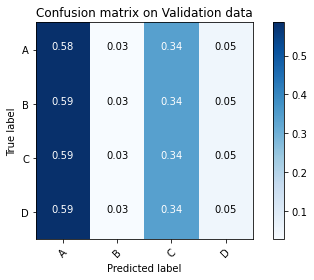

In [10]:
conf_mat_val = confusion_matrix(np.argmax(train_predicted_y, axis=1), y_train_)
plot_confusion_matrix(conf_mat_val, ["A", "B", "C", "D"], title='Confusion matrix on Validation data', normalize=True)

### Test Confusion matrix on RANDOM MODEL

Normalized confusion matrix
[[0.58547905 0.02678138 0.33934053 0.04839904]
 [0.5850819  0.02675266 0.33972563 0.0484398 ]
 [0.58485779 0.02689144 0.33985609 0.04839468]
 [0.58570251 0.02689647 0.33924244 0.04815858]]


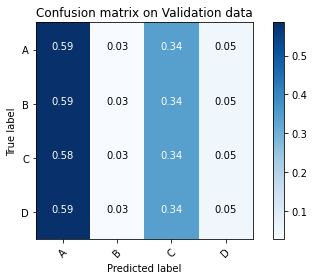

In [11]:
conf_mat_val = confusion_matrix(np.argmax(test_predicted_y, axis=1), y_test_)
plot_confusion_matrix(conf_mat_val, ["A", "B", "C", "D"], title='Confusion matrix on Validation data', normalize=True)

# Random Forest

In [31]:
RF_rs = RandomForestClassifier()

params = {"n_estimators":[5, 10, 20],
"max_depth" : [100, 200],}
    
rs = RandomizedSearchCV(RF_rs, params, cv=2, return_train_score=True, n_jobs=-1, verbose=200)
rs.fit(X_train_fe, y_train)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [100, 200],
                                        'n_estimators': [5, 10, 20]},
                   return_train_score=True, verbose=200)

In [32]:
rs.best_params_

{'n_estimators': 20, 'max_depth': 200}

In [34]:
rs.best_score_

0.9868724087915158

In [35]:
RF = RandomForestClassifier(n_estimators = 20, max_depth = 200)
RF.fit(X_train_fe, y_train)

RandomForestClassifier(max_depth=200, n_estimators=20)

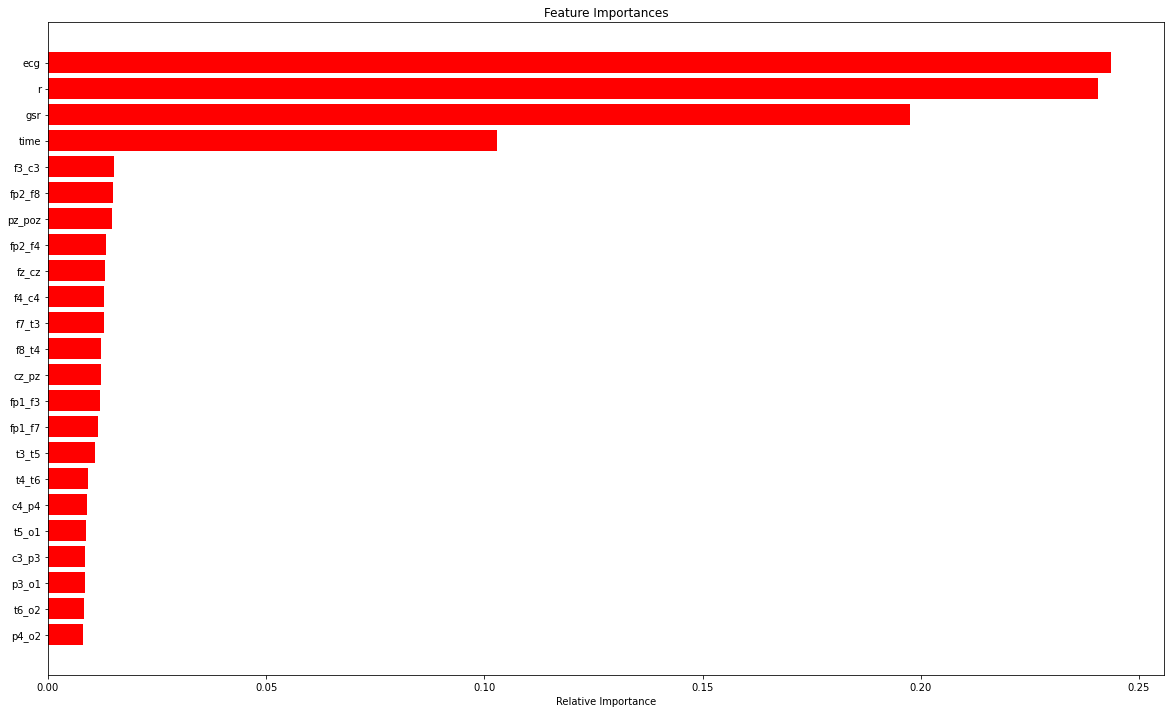

In [36]:
importances = RF.feature_importances_
indices = (np.argsort(importances))[:]
plt.figure(figsize=(20,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
   

In [4]:
# joblib.dump(X_train_fe, "X_train_fe")
# joblib.dump(X_test_fe, "X_test_fe")
# joblib.dump(y_train, "y_train")
# joblib.dump(y_test, "y_test")
# joblib.dump(scaler, "scaler")

# X_train_fe = joblib.load("X_train_fe")
# X_test_fe = joblib.load("X_test_fe")
# y_train = joblib.load("y_train")
# y_test = joblib.load("y_Test")

In [9]:
y_train_pred = RF.predict_proba(X_train_fe)
y_test_pred = RF.predict_proba(X_test_fe)

In [12]:
print(f"Train log_loss:{log_loss(y_train, y_train_pred)}")
print(f"Test log_loss:{log_loss(y_test, y_test_pred)}")

Train log_loss:0.08983134
Test log_loss:0.10121189


In [8]:
import joblib
RF = joblib.load('Random_forest_fe.pkl')

# Light GBM

In [5]:
d = {'A': 0, 'B': 1, 'C': 2, 'D': 3}

y_train_ = np.array(list(map(lambda x: d[x], y_train)))
y_test_ =  np.array(list(map(lambda x: d[x], y_test)))


In [6]:
train = lgbm.Dataset(X_train_fe, label = y_train_)



test = lgbm.Dataset(X_test_fe, label = y_test_)
 



# Declaring the hyperparameter values. 
params = {
      "objective" : "multiclass", # used for multiclass softmax classifier
      "metric" : "multi_error",   # Error rate for multiclass classification 
      "boosting" :'gbdt',         # Using Gardient Boosted Decision Trees
      'num_class':4,              # Number of desired output classes is 4 
      "num_leaves" : 59,          # Number of leaves in Tree based algorithms
      "learning_rate" : 0.01,     
      "bagging_fraction" : 0.9,   # This is randomly select 90% of data without resampling\
                   # it will decrease impact of high variance on data
      "bagging_seed" : 0,         # Random seeds for bagging
      "num_threads" : 4,
      "colsample_bytree" : 0.5,   # Subsampling fraction for feature
      'min_data_in_leaf':100,     # Threshold on Data in a leaf
      'min_split_gain':0.00019    # Minmimum gain threshold for splitting the node
        }




# Training Stage:
print('<start>Training')
model = lgbm.train(  params, 
                  train_set = train,
                  num_boost_round=2000,
                  early_stopping_rounds=200,
                  verbose_eval=100, 
                  valid_sets=[train,test]
                )
print('<complete>Training')

<start>Training
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.258227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 3893936, number of used features: 23
[LightGBM] [Info] Start training from score -0.535663
[LightGBM] [Info] Start training from score -3.618199
[LightGBM] [Info] Start training from score -1.080163
[LightGBM] [Info] Start training from score -3.029336
Training until validation scores don't improve for 200 rounds
[100]	training's multi_error: 0.0904329	valid_1's multi_error: 0.0903958
[200]	training's multi_error: 0.0625085	valid_1's multi_error: 0.0625546
[300]	training's multi_error: 0.0473945	valid_1's multi_error: 0.0474912
[400]	training's multi_error: 0.0344582	valid_1's multi_error: 0.0345141
[500]	training's multi_error: 0.0260677	valid_1's multi_error: 0.0262829
[600]	training's multi_error: 0.0211809	valid_1

In [3]:
# joblib.dump(model, "model_fe")
# import joblib
# model = joblib.load("model_fe")

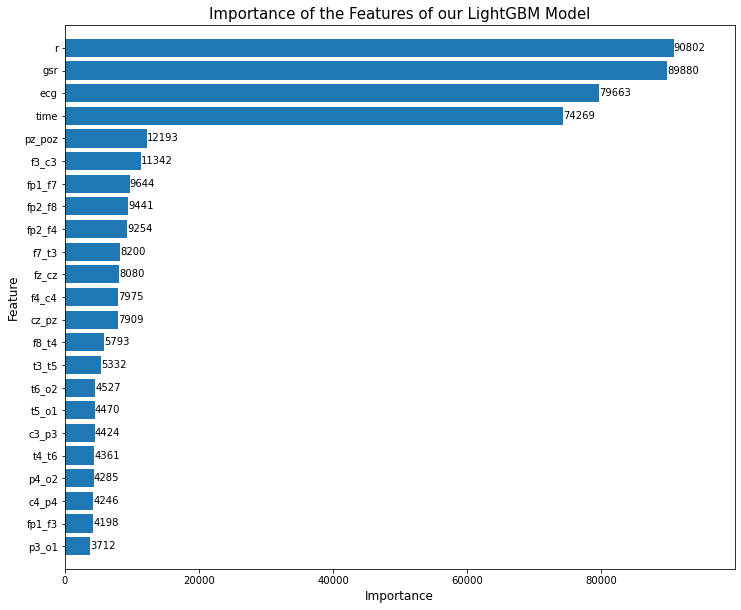

In [10]:
fig, ax = plt.subplots(figsize=(12,10))
lgbm.plot_importance(model, height=0.8, ax=ax)
ax.grid(False)
plt.ylabel('Feature', size=12)
plt.xlabel('Importance', size=12)
plt.title("Importance of the Features of our LightGBM Model", fontsize=15)
plt.show()

In [6]:
# y_train_pred = model.predict(X_train_fe)
# y_test_pred = model.predict(X_test_fe)

In [8]:
print(f"Train log_loss:{log_loss(y_train, y_train_pred)}")
print(f"Test log_loss:{log_loss(y_test, y_test_pred)}")

Train log_loss:0.0324
Test log_loss:0.04024


In [3]:
test_df = pd.read_csv("test.csv")

In [7]:
test_df_ = test_df.drop(['crew', 'experiment', 'seat', 'id'], axis=1 )
test_df_fe = get_new_features(test_df_)

In [3]:
# joblib.dump(test_df_fe, "test_df_fe")
test_df_fe = joblib.load("test_df_fe")

In [4]:
y_pred = model.predict(test_df_fe)

In [7]:
sub = pd.DataFrame(np.concatenate((np.arange(len(test_df_fe))[:, np.newaxis], y_pred), axis=1), columns=['id', 'A', 'B', 'C', 'D'],)
sub['id'] = sub['id'].astype(int)

In [12]:
model.feature_importance

'<bound method Booster.feature_importance of <lightgbm.basic.Booster object at 0x00000297F5E06D00>>'

In [8]:
sub.to_csv('result_lgbm_fe.csv', index=False)

### Results on Kaggle dataset

![title](LGBM_fe_score.png)

### Results are better than NO feature engineered data(only normalized)

# Selecting only top 16 features

In [5]:
feature_16 = ["r", "gsr", "ecg", "pz_poz", "f3_c3", "fp1_f7" ,"fp2_f4", "f7_t3", "fz_cz", "f4_c4", "cz_pz", "f8_t4", "t3_t5", "t6_o2", "t5_o1", "c3_p3"]

In [6]:
# X_train_fe = joblib.load("X_train_fe")
# X_test_fe = joblib.load("X_test_fe")
# y_train = joblib.load("y_train")
# y_test = joblib.load("y_Test")

In [7]:
X_train_fe_16 = X_train_fe[feature_16]
X_test_fe_16 = X_test_fe[feature_16]

In [21]:
d = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
y_train_ = np.array(list(map(lambda x: d[x], y_train)))
y_test_ =  np.array(list(map(lambda x: d[x], y_test)))

In [22]:
train = lgbm.Dataset(X_train_fe_16, label = y_train_)
test = lgbm.Dataset(X_test_fe_16, label = y_test_)
 



# Declaring the hyperparameter values. 
params = {
      "objective" : "multiclass", # used for multiclass softmax classifier
      "metric" : "multi_error",   # Error rate for multiclass classification 
      "boosting" :'gbdt',         # Using Gardient Boosted Decision Trees
      'num_class':4,              # Number of desired output classes is 4 
      "num_leaves" : 40,          # Number of leaves in Tree based algorithms
      "learning_rate" : 0.01,     
      "bagging_fraction" : 0.9,   # This is randomly select 90% of data without resampling\
                   # it will decrease impact of high variance on data
      "bagging_seed" : 0,         # Random seeds for bagging
      "num_threads" : 4,
      "colsample_bytree" : 0.5,   # Subsampling fraction for feature
      'min_data_in_leaf':100,     # Threshold on Data in a leaf
      'min_split_gain':0.00019    # Minmimum gain threshold for splitting the node
        }




# Training Stage:
print('<start>Training')
model = lgbm.train(  params, 
                  train_set = train,
                  num_boost_round=1000,
                  early_stopping_rounds=200,
                  verbose_eval=200, 
                  valid_sets=[train,test]
                )
print('<complete>Training')

<start>Training
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 3893936, number of used features: 16
[LightGBM] [Info] Start training from score -0.535663
[LightGBM] [Info] Start training from score -3.618199
[LightGBM] [Info] Start training from score -1.080163
[LightGBM] [Info] Start training from score -3.029336
Training until validation scores don't improve for 200 rounds
[200]	training's multi_error: 0.101366	valid_1's multi_error: 0.101402
[400]	training's multi_error: 0.0911936	valid_1's multi_error: 0.0912556
[600]	training's multi_error: 0.0824631	valid_1's multi_error: 0.0826114
[800]	training's multi_error: 0.0764386	valid_1's multi_error: 0.0767439
[1000]	training's multi_error: 0.0720895	valid_1's multi_error: 0.0725158
Did not meet early stopping. Best iteration is:


In [23]:
joblib.dump(model, "model_fe_16")
# model = joblib.load("model_fe_16")

['model_fe_16']

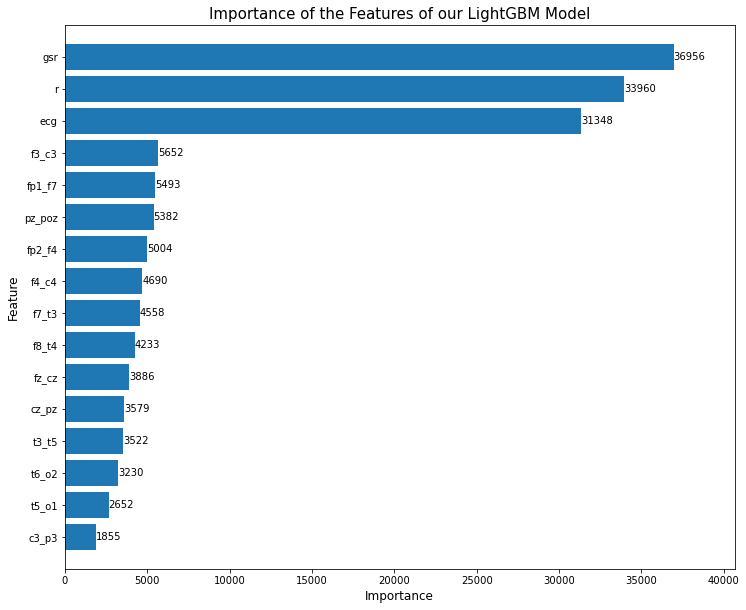

In [13]:
fig, ax = plt.subplots(figsize=(12,10))
lgbm.plot_importance(model, height=0.8, ax=ax)
ax.grid(False)
plt.ylabel('Feature', size=12)
plt.xlabel('Importance', size=12)
plt.title("Importance of the Features of our LightGBM Model", fontsize=15)
plt.show()

In [24]:
y_train_pred = model.predict(X_train_fe_16)
y_test_pred = model.predict(X_test_fe_16)

In [26]:
print(f"Train log_loss:{log_loss(y_train_, y_train_pred)}")
print(f"Test log_loss:{log_loss(y_test_, y_test_pred)}")

Train log_loss:0.21101605248555028
Test log_loss:0.21178669528772975


In [9]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Confusion matrix on Train data

Normalized confusion matrix
[[8.97390046e-01 2.04314088e-02 1.59750121e-02 6.62035330e-02]
 [6.45400862e-02 9.35206318e-01 2.53595624e-04 0.00000000e+00]
 [1.20194602e-02 1.09428724e-03 9.86406829e-01 4.79424014e-04]
 [4.88332282e-02 0.00000000e+00 5.04549959e-03 9.46121272e-01]]


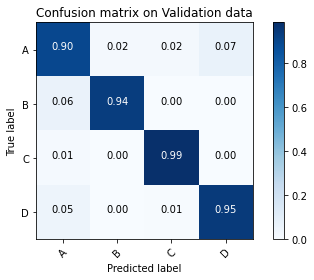

In [29]:
conf_mat_val = confusion_matrix(np.argmax(y_train_pred, axis=1), y_train_)
plot_confusion_matrix(conf_mat_val, ["A", "B", "C", "D"], title='Confusion matrix on Validation data', normalize=True)

### Confusion matrix on Test data

Normalized confusion matrix
[[8.97021554e-01 2.05798000e-02 1.61323895e-02 6.62662567e-02]
 [6.73665792e-02 9.32341791e-01 2.91630213e-04 0.00000000e+00]
 [1.23608405e-02 1.16652354e-03 9.86004795e-01 4.67840577e-04]
 [5.02084466e-02 0.00000000e+00 5.61899583e-03 9.44172558e-01]]


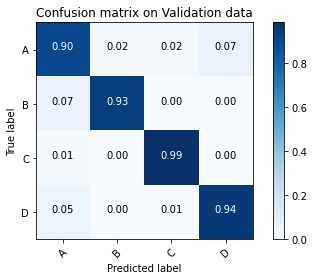

In [30]:
conf_mat_val = confusion_matrix(np.argmax(y_test_pred, axis=1), y_test_)
plot_confusion_matrix(conf_mat_val, ["A", "B", "C", "D"], title='Confusion matrix on Validation data', normalize=True)

#### Greate results!

#### Testing on Kaggle data

In [5]:
# joblib.dump(test_df_fe, "test_df_fe")
test_df_fe_16 = joblib.load("test_df_fe")[feature_16]

In [6]:
y_pred_16 = model.predict(test_df_fe_16)

In [8]:
sub = pd.DataFrame(np.concatenate((np.arange(len(test_df_fe_16))[:, np.newaxis], y_pred_16), axis=1), columns=['id', 'A', 'B', 'C', 'D'],)
sub['id'] = sub['id'].astype(int)

In [9]:
sub.to_csv('result_lgbm_fe_16.csv', index=False)

## Lets Check What's the status on Kaggle dataset

![title](LGBM_fe_16_score.png)

### Oh, results are better If take only important features than taking all features!

### Let's try Neural network on  top 16 features

In [8]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model, Sequential
 
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# CuDNNLSTM
from tensorflow.keras.layers import Embedding
from keras import initializers
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Concatenate, MaxPooling1D
from keras.layers import Flatten, Dropout
from tensorflow import keras
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, TensorBoard, LearningRateScheduler
from sklearn.metrics import recall_score, f1_score, roc_curve, auc
import datetime
 

In [11]:
from sklearn.preprocessing import LabelBinarizer
label_as_binary = LabelBinarizer()
f = label_as_binary.fit(y_train)
y_train_e = f.transform(y_train)
y_test_e = f.transform(y_test)

In [12]:
X_train_fe.head()

,time,ecg,r,gsr,fp1_f7,f7_t3,t3_t5,t5_o1,fp1_f3,f3_c3,...,cz_pz,pz_poz,fp2_f8,f8_t4,t4_t6,t6_o2,fp2_f4,f4_c4,c4_p4,p4_o2
1801191,21.109375,5862.399902,828.447998,661.953979,4.013599,7.490551,12.518730,-15.817580,4.013599,15.25740,...,18.42991,2.848100,-0.773400,10.163530,-1.480850,-1.872110,-9.237801,5.393700,3.063901,6.817370
2819484,57.550781,10847.299805,795.296997,1624.750000,8.736801,17.285600,-16.402400,25.702500,8.736801,3.59130,...,12.16164,-5.528600,25.515019,39.235179,25.402298,-47.857798,12.855049,70.952350,-21.023300,-20.489401
2329712,167.773438,-2221.330078,650.447021,1710.900024,-1.425260,8.166870,-15.972480,12.283575,-1.425260,3.26098,...,5.72684,0.647175,-3.759060,50.490299,-49.567999,11.289593,-4.581860,-13.235401,22.528171,3.741923
2761553,279.351562,10732.000000,795.906982,1764.699951,-10.335180,-4.266648,-4.959792,13.634600,-10.335180,-0.33520,...,-2.07110,-3.784310,1.375000,-11.188350,9.267650,-10.653000,3.912599,-12.061799,-12.947790,9.898290
3186090,53.453125,9927.769531,798.146973,1843.510010,4.126101,-11.868400,-3.342620,-11.988410,4.126101,-3.37750,...,0.75195,-0.915070,-3.727420,-9.086660,6.833970,-12.458280,-12.942530,-0.690480,-0.005250,-4.800130


In [20]:
inputs = tf.keras.Input(shape=(23,))
x = Dense(128, activation="relu")(inputs)
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
x = Dense(16, activation="relu")(x) 
x = Dense(8, activation="relu")(x) 
states = Dense(4, activation="softmax")(x)  
model = Model(inputs=inputs, outputs=states, name="mnist_model")

In [21]:
model.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 23)]              0         
                                                                 
 dense_15 (Dense)            (None, 128)               3072      
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 16)                528       
                                                                 
 dense_19 (Dense)            (None, 8)                 136       
                                                                 
 dense_20 (Dense)            (None, 4)                 

In [22]:
import datetime 
filepath="model_save_fe/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')
log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)

In [23]:
import shutil
try:
    shutil.rmtree('./logs/')
except:
    print("Not found")
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

In [24]:
history = model.fit(X_train_fe,y_train_e,epochs=10, validation_data=(X_test_fe,y_test_e), batch_size=128, callbacks=[checkpoint,\
                                                                                              tensorboard_callback])

Epoch 1/10
30417/30422 [============================>.] - ETA: 0s - loss: 1.0381 - accuracy: 0.5643
Epoch 1: val_accuracy improved from -inf to 0.66605, saving model to model_save_fe\weights-01-0.6660.hdf5
30422/30422 [==============================] - 104s 3ms/step - loss: 1.0381 - accuracy: 0.5643 - val_loss: 0.9207 - val_accuracy: 0.6660
Epoch 2/10
30406/30422 [============================>.] - ETA: 0s - loss: 0.9265 - accuracy: 0.5651
Epoch 2: val_accuracy did not improve from 0.66605
30422/30422 [==============================] - 86s 3ms/step - loss: 0.9265 - accuracy: 0.5651 - val_loss: 0.9185 - val_accuracy: 0.6660
Epoch 3/10
30410/30422 [============================>.] - ETA: 0s - loss: 0.9265 - accuracy: 0.5651
Epoch 3: val_accuracy did not improve from 0.66605
30422/30422 [==============================] - 78s 3ms/step - loss: 0.9265 - accuracy: 0.5651 - val_loss: 0.9169 - val_accuracy: 0.6660
Epoch 4/10
30416/30422 [============================>.] - ETA: 0s - loss: 0.9265 - 

# Using this neural network trained on top 16 features won't be helpful as accuracy not increasing after 1 epoch!

In [1]:
# test_df_fe_16 = joblib.load("test_df_fe")[feature_16]
# y_pred_16 = model.predict(test_df_fe_16)
# sub = pd.DataFrame(np.concatenate((np.arange(len(test_df_fe_16))[:, np.newaxis], y_pred_16), axis=1), columns=['id', 'A', 'B', 'C', 'D'],)
# sub['id'] = sub['id'].astype(int)

# Summary

Log loss on TRAIN Data using Random Model **1.6453471449107933**

Log loss on TEST Data using Random Model **1.6453310877290241**

In [2]:
from prettytable import PrettyTable 

myTable = PrettyTable(["Model", "Approach","train logloss", "cv logloss", "Kaggle score(private)"])
  
myTable.add_row(["Random forest","FE + No min-max scaling", "0.08983134", "0.10121189", "5.52"])
myTable.add_row(["Light GBM","FE + No min-max scaling", "0.03", "0.04", "1.13"])
myTable.add_row(["Light GBM","FE + No min-max scaling + Top 16 features", "0.21", "0.21", "0.852"])
print(myTable)

+---------------+-------------------------------------------+---------------+------------+-----------------------+
|     Model     |                  Approach                 | train logloss | cv logloss | Kaggle score(private) |
+---------------+-------------------------------------------+---------------+------------+-----------------------+
| Random forest |          FE + No min-max scaling          |   0.08983134  | 0.10121189 |          5.52         |
|   Light GBM   |          FE + No min-max scaling          |      0.03     |    0.04    |          1.13         |
|   Light GBM   | FE + No min-max scaling + Top 16 features |      0.21     |    0.21    |         0.852         |
+---------------+-------------------------------------------+---------------+------------+-----------------------+


Better performance than Random model!